## CDS110 HW8 P2 Skeleton

The lateral dynamics of a PVTOL


In [ ]:
!pip3 install control

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import control as ct
from math import sin, cos

## System definition and setup...

In [ ]:
pvtol_params = {'m': 4., # mass of aircraft
'J': 0.0475, # inertia around pitch axis
'r': 0.25, # distance to center of force
'g': 9.8, # gravitational constant
'c': 0.05, # damping factor (estimated)
'F2e': 9.8 * 4 # equilibrium vertical thrust
}

def pvtol_update(t, x, u, params):
    # Get the parameter values
    m, J, r, g, c, F2e = map(
    params.get, ['m', 'J', 'r', 'g', 'c', 'F2e'])

    # Extract the inputs and states into individual variables
    F1 = u[0]
    xpos, theta, xdot, thdot = x

    # Dynamics
    xddot = (F1 * cos(theta) - F2e * sin(theta) - c * xdot) / m
    thddot = (r * F1) / J
    return np.array([xdot, thdot, xddot, thddot])


def pvtol_output(t, x, u, params):
    # Extract the inputs and states into individual variables
    F1 = u[0]
    xpos, theta, xdot, thdot = x
    return xpos


pvtol = ct.nlsys(
pvtol_update, pvtol_output, name='pvtol',
states=['x', 'theta', 'xdot', 'thdot'],
inputs=['F1'],
outputs=['x'],
params=pvtol_params
)
print(pvtol)

<NonlinearIOSystem>: pvtol
Inputs (1): ['F1']
Outputs (1): ['x']
States (4): ['x', 'theta', 'xdot', 'thdot']

Update: <function pvtol_update at 0x7fc444b460e0>
Output: <function pvtol_output at 0x7fc444b45900>


## Linearize the system about the vertical equilibrium point

In [ ]:
# Find the equiblrium point corresponding to the origin
xe, ue = ct.find_eqpt(pvtol, [0, 0, 0, 0], [0])
print(f"{xe=}")
print(f"{ue=}")
# Extract the linearization for use in LQR design
pvtol_lin = pvtol.linearize(xe, ue)
A, B, C, D = pvtol_lin.A, pvtol_lin.B, pvtol_lin.C, pvtol_lin.D
P = ct.ss(A, B, C, D)
print(P)

xe=array([0., 0., 0., 0.])
ue=array([0])
<StateSpace>: sys[1]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']
States (4): ['x[0]', 'x[1]', 'x[2]', 'x[3]']

A = [[ 0.      0.      1.      0.    ]
     [ 0.      0.      0.      1.    ]
     [ 0.     -9.8    -0.0125  0.    ]
     [ 0.      0.      0.      0.    ]]

B = [[0.        ]
     [0.        ]
     [0.25      ]
     [5.26315789]]

C = [[1. 0. 0. 0.]]

D = [[0.]]



### Part A

In [ ]:
def compute_estimator_gains():
    eigen_vals = np.array([-3.83 + 9.24j, -3.83 - 9.24j,  -9.24 + 3.83j,  -9.24 - 3.83j])
    L = ct.place(A.T, C.T, eigen_vals)
    return L.T

In [ ]:
# Estimator update law
def estimator_update(t, xhat, u, params):
    # Extract the inputs to the estimator
    x, F1 = u

    # Update the state estimate
    xhatdot = pvtol_update(t, xhat, [F1], pvtol_params) - params['L'] @ (C @ xhat - x)
    return xhatdot

L = compute_estimator_gains()
estimator = ct.nlsys(
estimator_update, None, name='estimator',
states=pvtol.nstates, params={'L': L},
inputs=['x', 'F1'],
outputs=['xhat', 'thhat', 'xdothat', 'thdothat'],
)

print(estimator)

<NonlinearIOSystem>: estimator
Inputs (2): ['x', 'F1']
Outputs (4): ['xhat', 'thhat', 'xdothat', 'thdothat']
States (4): ['x[0]', 'x[1]', 'x[2]', 'x[3]']

Update: <function estimator_update at 0x7fc408c09b40>
Output: None


Text(0.5, 0.98, 'Butterworth estimator response')

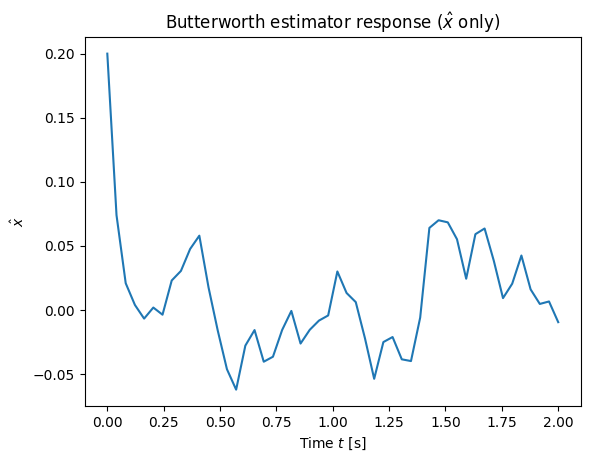

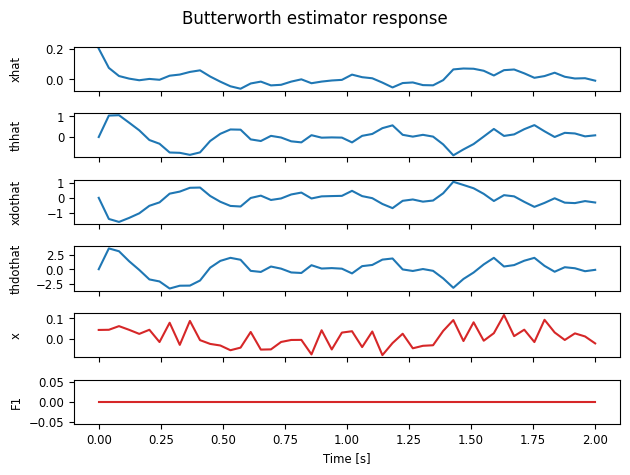

In [ ]:
# Initial condition response of the estimator
T = np.linspace(0, 2)
n = ct.white_noise(T, 1e-4)
estresp = ct.input_output_response(estimator , T, [n, 0], X0=[0.2, 0, 0, 0])

# Plot response of x_hat
plt.plot(T, estresp.states.T[:,0])
plt.xlabel("Time $t$ [s]")
plt.ylabel("$\hat{x}$")
plt.title("Butterworth estimator response ($\hat{x}$ only)")

# Plot response of all variables
estresp.plot()
plt.suptitle("Butterworth estimator response")

### Part B

In [ ]:
# Disturbance and noise covariances
Rv = 1e-1
Rw = 1e-4
def compute_kalman_gain():
    #ct.lqr(A.T, C.T, Q, Rw)
    Q = Rv * np.eye(A.shape[0])
    _, P, _ = ct.lqr(A.T, C.T, Q, Rw)

    #np.linalg.inv(Rw) = 1/Rw (since Rw is a scalar)
    #L_kf = P @ C.T @ np.linalg.inv(Rw)
    L_kf = (1/Rw)*(P @ C.T)
    return L_kf


Text(0.5, 0.98, 'Kalman filter response')

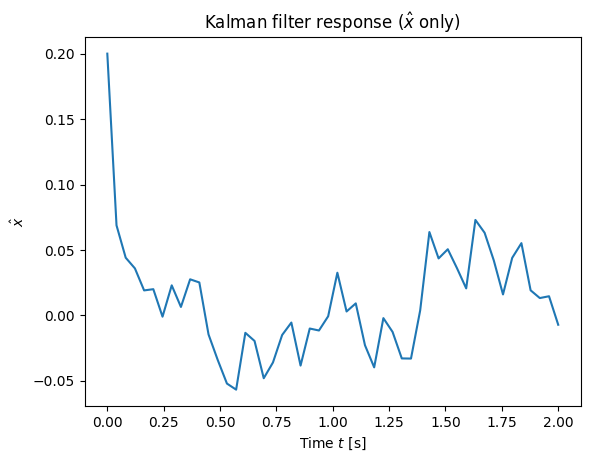

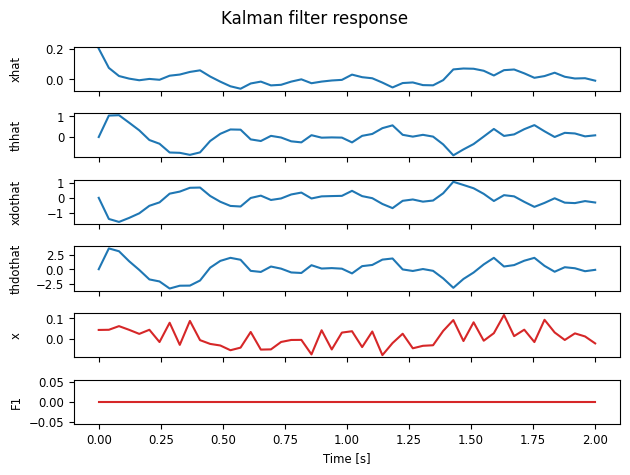

In [ ]:
L_kf = compute_kalman_gain()
kfresp = ct.input_output_response(
estimator, T, [n, 0], X0=[0.2, 0, 0, 0],
params={'L': L_kf})

# Plot response of x_hat
plt.plot(T, kfresp.states.T[:,0])
plt.xlabel("Time $t$ [s]")
plt.ylabel("$\hat{x}$")
plt.title("Kalman filter response ($\hat{x}$ only)")

# Plot response of all variables
estresp.plot()
plt.suptitle("Kalman filter response")

### Part C

In [ ]:
def compute_lqr_gain():
    Q = np.diag([1,1,1,1])
    R = np.array([[1]])
    K , P, _ = ct.lqr(A, B, Q, R)
    return K

def compute_feedfowrward_gain():
    kf = -1 / (C @ np.linalg.inv(A - B @ K) @ B)
    return kf[0, 0]

<NonlinearIOSystem>: ctrl
Inputs (5): ['r', 'xhat', 'thhat', 'xdothat', 'thdothat']
Outputs (1): ['F1']
States (0): []

Update: <function NonlinearIOSystem.__init__.<locals>.<lambda> at 0x7fc40695dd80>
Output: <function ctrl_output at 0x7fc403dbbb50>
<InterconnectedSystem>: clsys
Inputs (3): ['r', 'd', 'n']
Outputs (2): ['x', 'xhat']
States (8): ['pvtol_x', 'pvtol_theta', 'pvtol_xdot', 'pvtol_thdot', 'estimator_x[0]', 'estimator_x[1]', 'estimator_x[2]', 'estimator_x[3]']

Update: <function InterconnectedSystem.__init__.<locals>.updfcn at 0x7fc403cb0700>
Output: <function InterconnectedSystem.__init__.<locals>.outfcn at 0x7fc403cb0790>


Text(0.5, 0.98, 'Step response with Kalman filter')

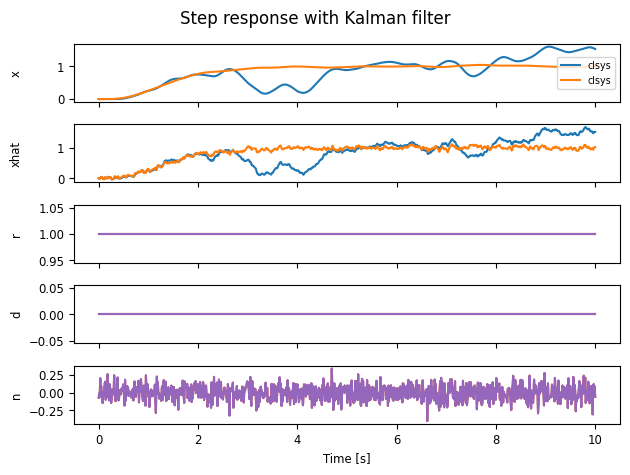

In [ ]:
K = compute_lqr_gain()
kf = compute_feedfowrward_gain()

# Construct the controller as an I/O system
def ctrl_output(t, x, u, params):
    r = u[0]
    xhat = u[1:5]
    return -K @ xhat + kf * r

ctrl = ct.nlsys(
None, ctrl_output, name='ctrl',
inputs=['r', 'xhat', 'thhat', 'xdothat', 'thdothat'],
outputs=['F1']
)
print(ctrl)

# Construct the closed loop system
clsys = ct.interconnect(
[pvtol, estimator, ctrl], name='clsys',
inplist=['r', 'pvtol.F1', 'estimator.x'],
inputs=['r', 'd', 'n'],
outputs=['x', 'xhat'])
print(clsys)

# Create noise and disturbance vectors
T = np.linspace(0, 10, 1000)
d = ct.white_noise(T, Rv)
n = ct.white_noise(T, Rw)

# Compute the step response, with noise for Butterworth
stepresp = ct.input_output_response(clsys, T, [1, 0, n], params={'L': L})
stepresp.plot()
plt.suptitle("Step response for Butterworth estimator")

# Compute the step response, with noise for Kalman filter
stepresp_kf = ct.input_output_response(clsys, T, [1, 0, n], params={'L': L_kf})
stepresp_kf.plot()
plt.suptitle("Step response with Kalman filter")